In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Vorverarbeitung

## Speech Daten

In [2]:
#Einlesen der Speeches und Filtern der Präsidenten
df = pd.read_csv("presidential_speeches.csv")
df = df.drop(["Summary", "URL"], axis =1 )
df["Date"] = pd.to_datetime(df["Date"])
df = df[df.Date > datetime.datetime(1899, 12, 31)]
df = df[df.President != "Gerald Ford"]
df.reset_index(drop = True, inplace = True)
df.head()

,Date,President,Party,Speech Title,Transcript
0,1900-07-12,William McKinley,Republican,Speech Accepting the Republican Nomination,Senator Lodge and Gentlemen of the Notificatio...
1,1900-12-03,William McKinley,Republican,Fourth Annual Message,To the Senate and House of Representatives: At...
2,1901-03-04,William McKinley,Republican,Second Inaugural Address,My Fellow Citizens: When we assembled here on ...
3,1901-09-05,William McKinley,Republican,"Speech in Buffalo, New York","President Milburn, Director General Buchanan, ..."
4,1901-09-14,Theodore Roosevelt,Republican,Announcement of the Death of President McKinley,By the President of the United States of Ameri...


In [3]:
replace_char = [":", ",", ";", ".", '"']
for m in range(0, len(df)):
    for i in replace_char:
        df.loc[m, "Transcript"] = df.loc[m, "Transcript"].replace(i,'')

In [4]:
#Erstellen eines Dictionaries mit allen Präsidenten und deren Partei
presidents_unique = list(df.President.unique())
print(presidents_unique)
president_party_dic = {}
for president in presidents_unique:
    president_party_dic[president] = list(df.Party[df.President == president])[0]

['William McKinley', 'Theodore Roosevelt', 'William Taft', 'Woodrow Wilson', 'Warren G. Harding', 'Calvin Coolidge', 'Herbert Hoover', 'Franklin D. Roosevelt', 'Harry S. Truman', 'Richard M. Nixon', 'Dwight D. Eisenhower', 'John F. Kennedy', 'Lyndon B. Johnson', 'Ronald Reagan', 'Jimmy Carter', 'George H. W. Bush', 'Bill Clinton', 'George W. Bush', 'Barack Obama', 'Donald Trump']


In [5]:
#Aufspalten der Datenbasis in ein Trainingsdataframe (alle Reden bis auf 2 pro Präsident --> Die sind im test_df)
def test_train_split(df):
    df = df.sample(frac=1).reset_index(drop=True)
    test_df = pd.DataFrame(columns = list(df.columns))
    known_president = {}
    for i in range(0,len(df)):
        pres = df.loc[i,"President"]
        if not(pres in known_president):
            known_president[df.loc[i,"President"]] = 1
            test_df = test_df.append(df.loc[i,:])
            df = df.drop([i])
        elif known_president[pres]<2:
            known_president[pres] = 2
            test_df = test_df.append(df.loc[i,:])
            df = df.drop([i])
        else:
            continue
    df.reset_index(drop = True, inplace = True)
    test_df.reset_index(drop = True, inplace = True)
    return df, test_df

df, test_df = test_train_split(df)

## Zweite Dimension Daten

In [6]:
#https://www.statista.com/statistics/1034688/share-electoral-popular-votes-each-president-since-1789/
pv_df = pd.read_excel("Statista_PV.xlsx", sheet_name = "Data", usecols = "B:D" ,skiprows = 5, header = None)
pv_df.columns = ["President", "Electoral_College%", "PV_%"]

In [7]:
#Entfernen der Klammern mit Jahreszahlen aus dem DF, begrenzen der Präsidenten
pv_df.President = [x.split("(")[0] for x in list(pv_df.President) ]
pv_df = pv_df.loc[1:30,:]
pv_df.reset_index(drop = True, inplace = True)
pv_df['PV_%'] = pv_df['PV_%'].astype(float)
pv_df.head()

,President,Electoral_College%,PV_%
0,Donald Trump,56.69,46.0
1,Barack Obama,61.71,51.1
2,Barack Obama,67.84,52.9
3,George W. Bush,53.16,50.7
4,George W. Bush,50.37,47.9


In [8]:
#Durchschnitt der Popular Votes
pv_dic = {}
for i in range(0,len(pv_df)):
    name = str(pv_df.loc[i, "President"])[:-1:] # Leerzeichen nach Namen wird entfernt mit der eckigen Klammer
    if name == "Richard Nixon":
        name = "Richard M. Nixon"
    elif name == "William H. Taft": # Vereinzelt werden Namen angepasst, um einheitlich zu sein
        name = "William Taft"
    if not (name in pv_dic): 
        pv_dic[name] = [pv_df.loc[i, "PV_%"]]
    else:
        pv_dic[name].append(pv_df.loc[i, "PV_%"])
    #print(type(pv_dic[pv_df.loc[i, "President"]]))
for key in pv_dic:
    pv_dic[key] = sum(pv_dic[key])/len(pv_dic[key])
      
pv_dic

{'Donald Trump': 46.0,
 'Barack Obama': 52.0,
 'George W. Bush': 49.3,
 'Bill Clinton': 46.1,
 'George H. W. Bush': 53.4,
 'Ronald Reagan': 54.599999999999994,
 'Jimmy Carter': 50.0,
 'Richard M. Nixon': 52.05,
 'Lyndon B. Johnson': 61.1,
 'John F. Kennedy': 49.7,
 'Dwight D. Eisenhower': 56.15,
 'Harry S. Truman': 49.4,
 'Franklin D. Roosevelt': 56.375,
 'Herbert Hoover': 58.0,
 'Calvin Coolidge': 54.1,
 'Warren G. Harding': 60.3,
 'Woodrow Wilson': 45.5,
 'William Taft': 51.6,
 'Theodore Roosevelt': 56.4,
 'William McKinley': 51.7}

# Training

In [9]:
#Berechnen der Prior Probabilities
print("Party Count: ", df.Party.value_counts())
print("Anzahl Einträge: ", len(df))
prior = {"democratic": df.Party.value_counts()[0], "republican": df.Party.value_counts()[1]}
df_len = len(df)
prior

Party Count:  Democratic    311
Republican    243
Name: Party, dtype: int64
Anzahl Einträge:  554


{'democratic': 311, 'republican': 243}

In [10]:
#Zählen der vorkommenden Wörter und von welcher Partei diese benutzt wurden
def count_words(speech, party, word_dic):
    known_words = set()
    speech_words = speech.split(" ")
    for word in speech_words:
        word = word.lower()
        if (len(word)>2) and word.isalpha() and (not(word in known_words)):
            known_words.add(word)
            if not(word in word_dic):
                word_dic[word]={"republican":0,"democratic":0}
            if party=="Republican":
                word_dic[word]["republican"]=word_dic[word]["republican"]+1
            elif party=="Democratic":
                word_dic[word]["democratic"]=word_dic[word]["democratic"]+1
    return word_dic

In [11]:
#Durch das Dataframe durchiterieren um die jeweiligen transcripts zu analysieren
def iterate_df(df):
    word_dic = {}
    for i in range (0,len(df)):
        party = df.loc[i,"Party"]
        speech =df.loc[i, "Transcript"]
        word_dic = count_words(speech, party, word_dic)
    return word_dic
word_dic = iterate_df(df)

In [12]:
len(word_dic)

27897

In [13]:
#Entfernen von wörtern welche in jeder Rede jedes Präsidenten vorkamen
def check_dic(word_dic):
    final_words = {}
    for key in word_dic.keys():
        if word_dic[key]["republican"] != 243 or word_dic[key]["democratic"] != 311:
            final_words[key]={"republican":0,"democratic":0}
            final_words[key]["republican"] = word_dic[key]["republican"]
            final_words[key]["democratic"] = word_dic[key]["democratic"]
        else:
            print(key)
    return final_words
word_dic = check_dic(word_dic)

the
and


In [14]:
len(word_dic)

27895

# Prediction phase

In [15]:
#Vorhersagen der Wahrscheinlichkeit, dass die Rede von einem Demokraten stammt oder eines Republikaners. Dies geschieht
# mithilfer der Log-Likeliehood. Ausserdem wird für jeden Präsidenten der Durchschnitt errechnet.
def predict(transcript, prior, df_len, president, word_dic, president_dic): 
    prob_rep = 0
    prob_dem = 0
    if not(president in president_dic):
        president_dic[president] = {"prob_rep":0,"prob_dem":0}
       
    for word in transcript.split(" "):
        word = word.lower()
        if (len(word) > 2) and word.isalpha() and isWordNonZero(word):            
             
            prob_rep = prob_rep + np.log(word_dic[word]["republican"] / prior["republican"])
            prob_dem = prob_dem + np.log(word_dic[word]["democratic"] / prior["democratic"])
            
    prob_rep = prob_rep + np.log(prior["republican"] / df_len)
    prob_dem = prob_dem + np.log(prior["democratic"] / df_len)
    
    president_dic[president]["prob_rep"] = president_dic[president]["prob_rep"] + prob_rep
    president_dic[president]["prob_dem"] = president_dic[president]["prob_dem"] + prob_dem
    
    
    return president_dic
    
    
def isWordNonZero(word):
    if not(word in word_dic):
        return False
    if word_dic[word]["republican"] <= 0:
        return False
    if word_dic[word]["democratic"] <= 0:
        return False
    return True

def iterate_pred(test_df, prior, df_len, word_dic):
    president_dic = {}
    for i in range(0, len(test_df)):
        transcript = test_df.loc[i, "Transcript"]
        president = test_df.loc[i, "President"]
        president_dic = predict(transcript, prior, df_len, president, word_dic, president_dic)
    for key in president_dic.keys():
        president_dic[key]["prob_rep"] = president_dic[key]["prob_rep"] / 2
        president_dic[key]["prob_dem"] = president_dic[key]["prob_dem"] / 2
        
    return president_dic

president_dic = iterate_pred(test_df, prior, df_len, word_dic)
print(president_dic)

{'George W. Bush': {'prob_rep': -1914.5715473047953, 'prob_dem': -2063.648811715195}, 'John F. Kennedy': {'prob_rep': -1833.7483932018063, 'prob_dem': -1875.450599065186}, 'Barack Obama': {'prob_rep': -2529.716294675069, 'prob_dem': -2577.3459059217125}, 'Harry S. Truman': {'prob_rep': -1335.0768930810518, 'prob_dem': -1353.5854254916576}, 'Warren G. Harding': {'prob_rep': -2508.135558081071, 'prob_dem': -2895.7354601737743}, 'Franklin D. Roosevelt': {'prob_rep': -2439.438170535368, 'prob_dem': -2603.4840484640263}, 'Lyndon B. Johnson': {'prob_rep': -3113.6337466950226, 'prob_dem': -3223.4450514634054}, 'Jimmy Carter': {'prob_rep': -5490.8977703573255, 'prob_dem': -5828.950565968689}, 'Donald Trump': {'prob_rep': -2890.948819264414, 'prob_dem': -3102.563642579922}, 'Woodrow Wilson': {'prob_rep': -2110.9405326204937, 'prob_dem': -2293.5751968051477}, 'Calvin Coolidge': {'prob_rep': -5862.219430162534, 'prob_dem': -6886.452325985695}, 'Herbert Hoover': {'prob_rep': -4668.311516918835, 'p

# Evaluierung

In [16]:
president_party_dic

{'William McKinley': 'Republican',
 'Theodore Roosevelt': 'Republican',
 'William Taft': 'Republican',
 'Woodrow Wilson': 'Democratic',
 'Warren G. Harding': 'Republican',
 'Calvin Coolidge': 'Republican',
 'Herbert Hoover': 'Republican',
 'Franklin D. Roosevelt': 'Democratic',
 'Harry S. Truman': 'Democratic',
 'Richard M. Nixon': 'Republican',
 'Dwight D. Eisenhower': 'Republican',
 'John F. Kennedy': 'Democratic',
 'Lyndon B. Johnson': 'Democratic',
 'Ronald Reagan': 'Republican',
 'Jimmy Carter': 'Democratic',
 'George H. W. Bush': 'Republican',
 'Bill Clinton': 'Democratic',
 'George W. Bush': 'Republican',
 'Barack Obama': 'Democratic',
 'Donald Trump': 'Republican'}

In [17]:
# TD = True Democrat, TR = True Republican

def TD_FD_TR_FR(president_dic, president_party_dic):
    TD, FR, TR, FD, NR = 0, 0, 0, 0, 0
    for key in president_dic.keys():
        if president_dic[key]['prob_rep'] > president_dic[key]['prob_dem']:
            pred_party = "Republican"
        if president_dic[key]['prob_rep'] < president_dic[key]['prob_dem']:
            pred_party = "Democratic"
        if president_dic[key]['prob_rep'] == president_dic[key]['prob_dem']:
            pred_party = "no_result"
            NR  += 1
            continue
        if pred_party == president_party_dic[key]:
            if pred_party == "Republican":
                TR +=1
            else:
                TD +=1
        if pred_party != president_party_dic[key]:
            if pred_party == "Republican":
                FR +=1
            else:
                FD +=1
    accuracy = (TD+TR)/(len(president_dic.keys()))
    return accuracy

accuracy = TD_FD_TR_FR(president_dic, president_party_dic)
print("accuracy: ", accuracy)        
        

accuracy:  0.6


 # Visualisierungen

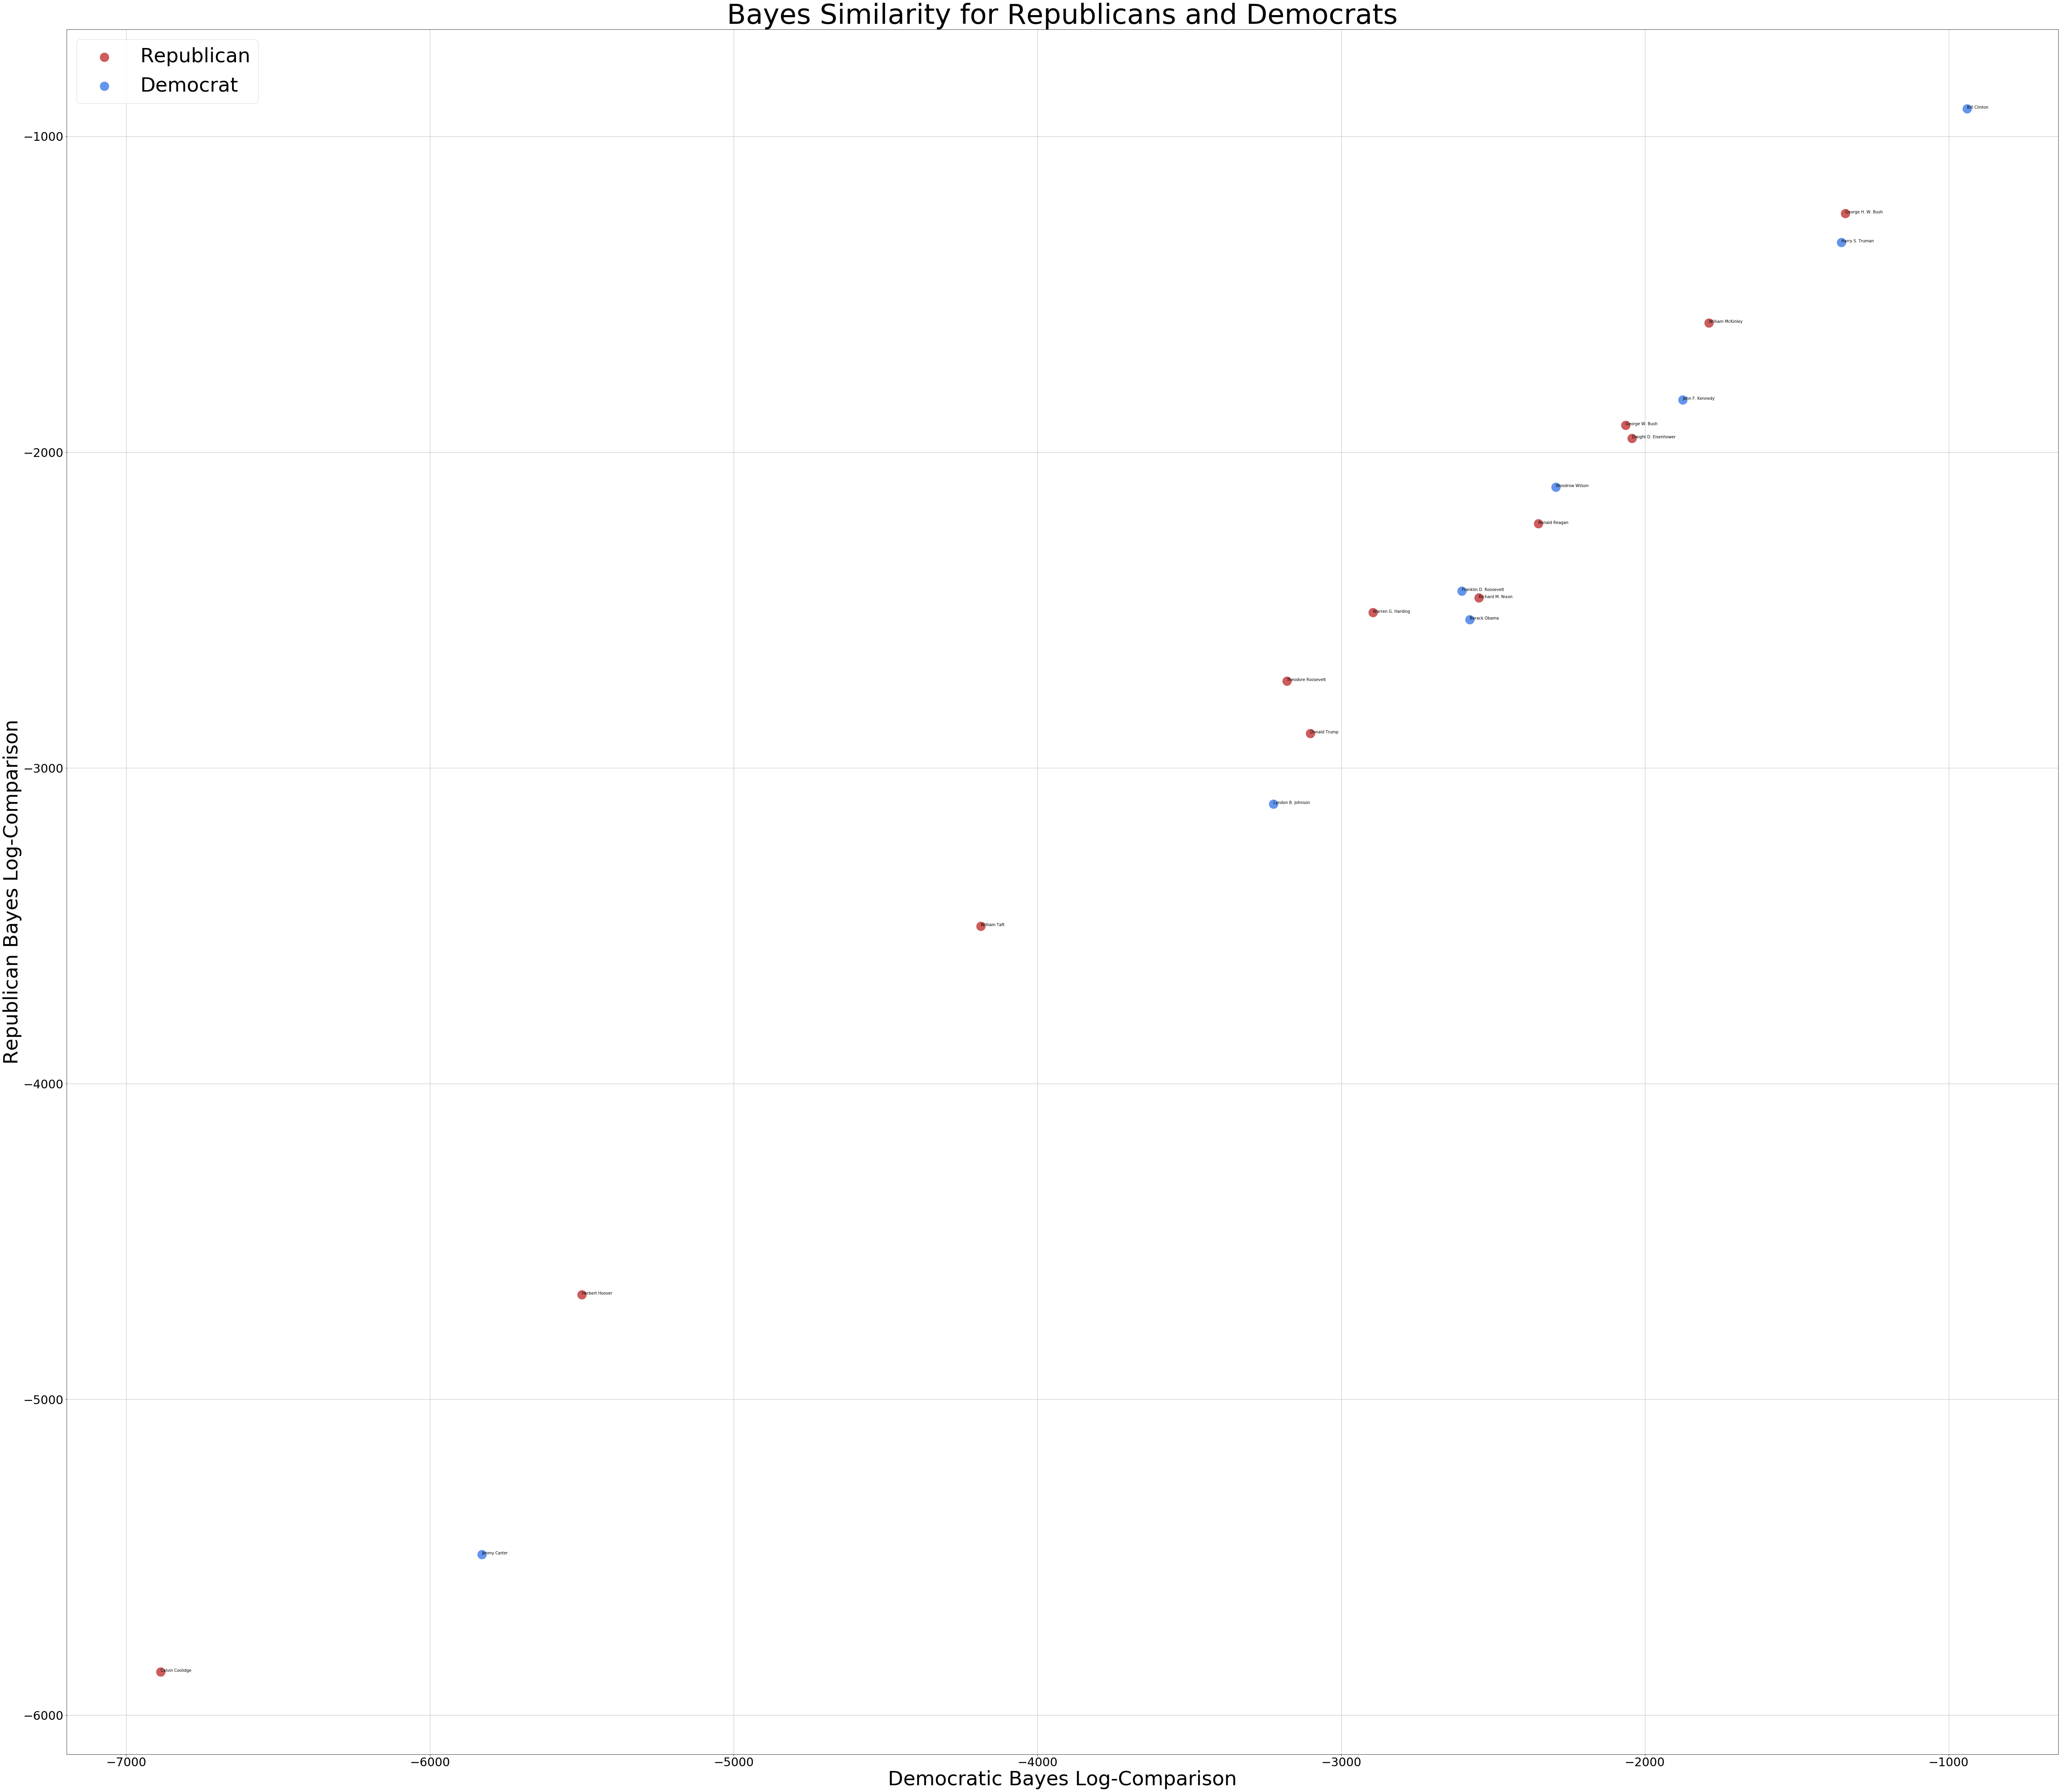

In [18]:
#Einordnen der Präsidenten anhand zweier Reden. X-Achse demokratisch,  Y-Achse Republikanisch
# Reden wurden im Vorhinein von Naive Bayes analysiert.
fig, ax = plt.subplots(figsize=(90,80))
my_labels = {"Rep" : "Republican", "Dem" : "Democrat"}
for key in pv_dic:
    party = president_party_dic[key]
    rep = president_dic[key]["prob_rep"]
    dem = president_dic[key]["prob_dem"]
    label = key
    if party == "Democratic":
        c = "cornflowerblue"
        ax.scatter(dem, rep, color = c, s = 500, label = my_labels["Dem"])
        my_labels["Dem"] = "_nolegend_"
    else:
        c = "indianred"
        ax.scatter(dem, rep, color = c, s = 500, label = my_labels["Rep"])
        my_labels["Rep"] = "_nolegend_"
           
    ax.annotate(label, (dem, rep))
    
ax.legend()
ax.legend(loc = 2, fontsize = 50)
ax.grid(True)
ax.set_ylabel('Republican Bayes Log-Comparison', size = 50)
ax.set_xlabel('Democratic Bayes Log-Comparison', size = 50)
ax.set_title('Bayes Similarity for Republicans and Democrats', size =70)
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.show()
fig.savefig("Scatterplot_Praesidenten.svg")

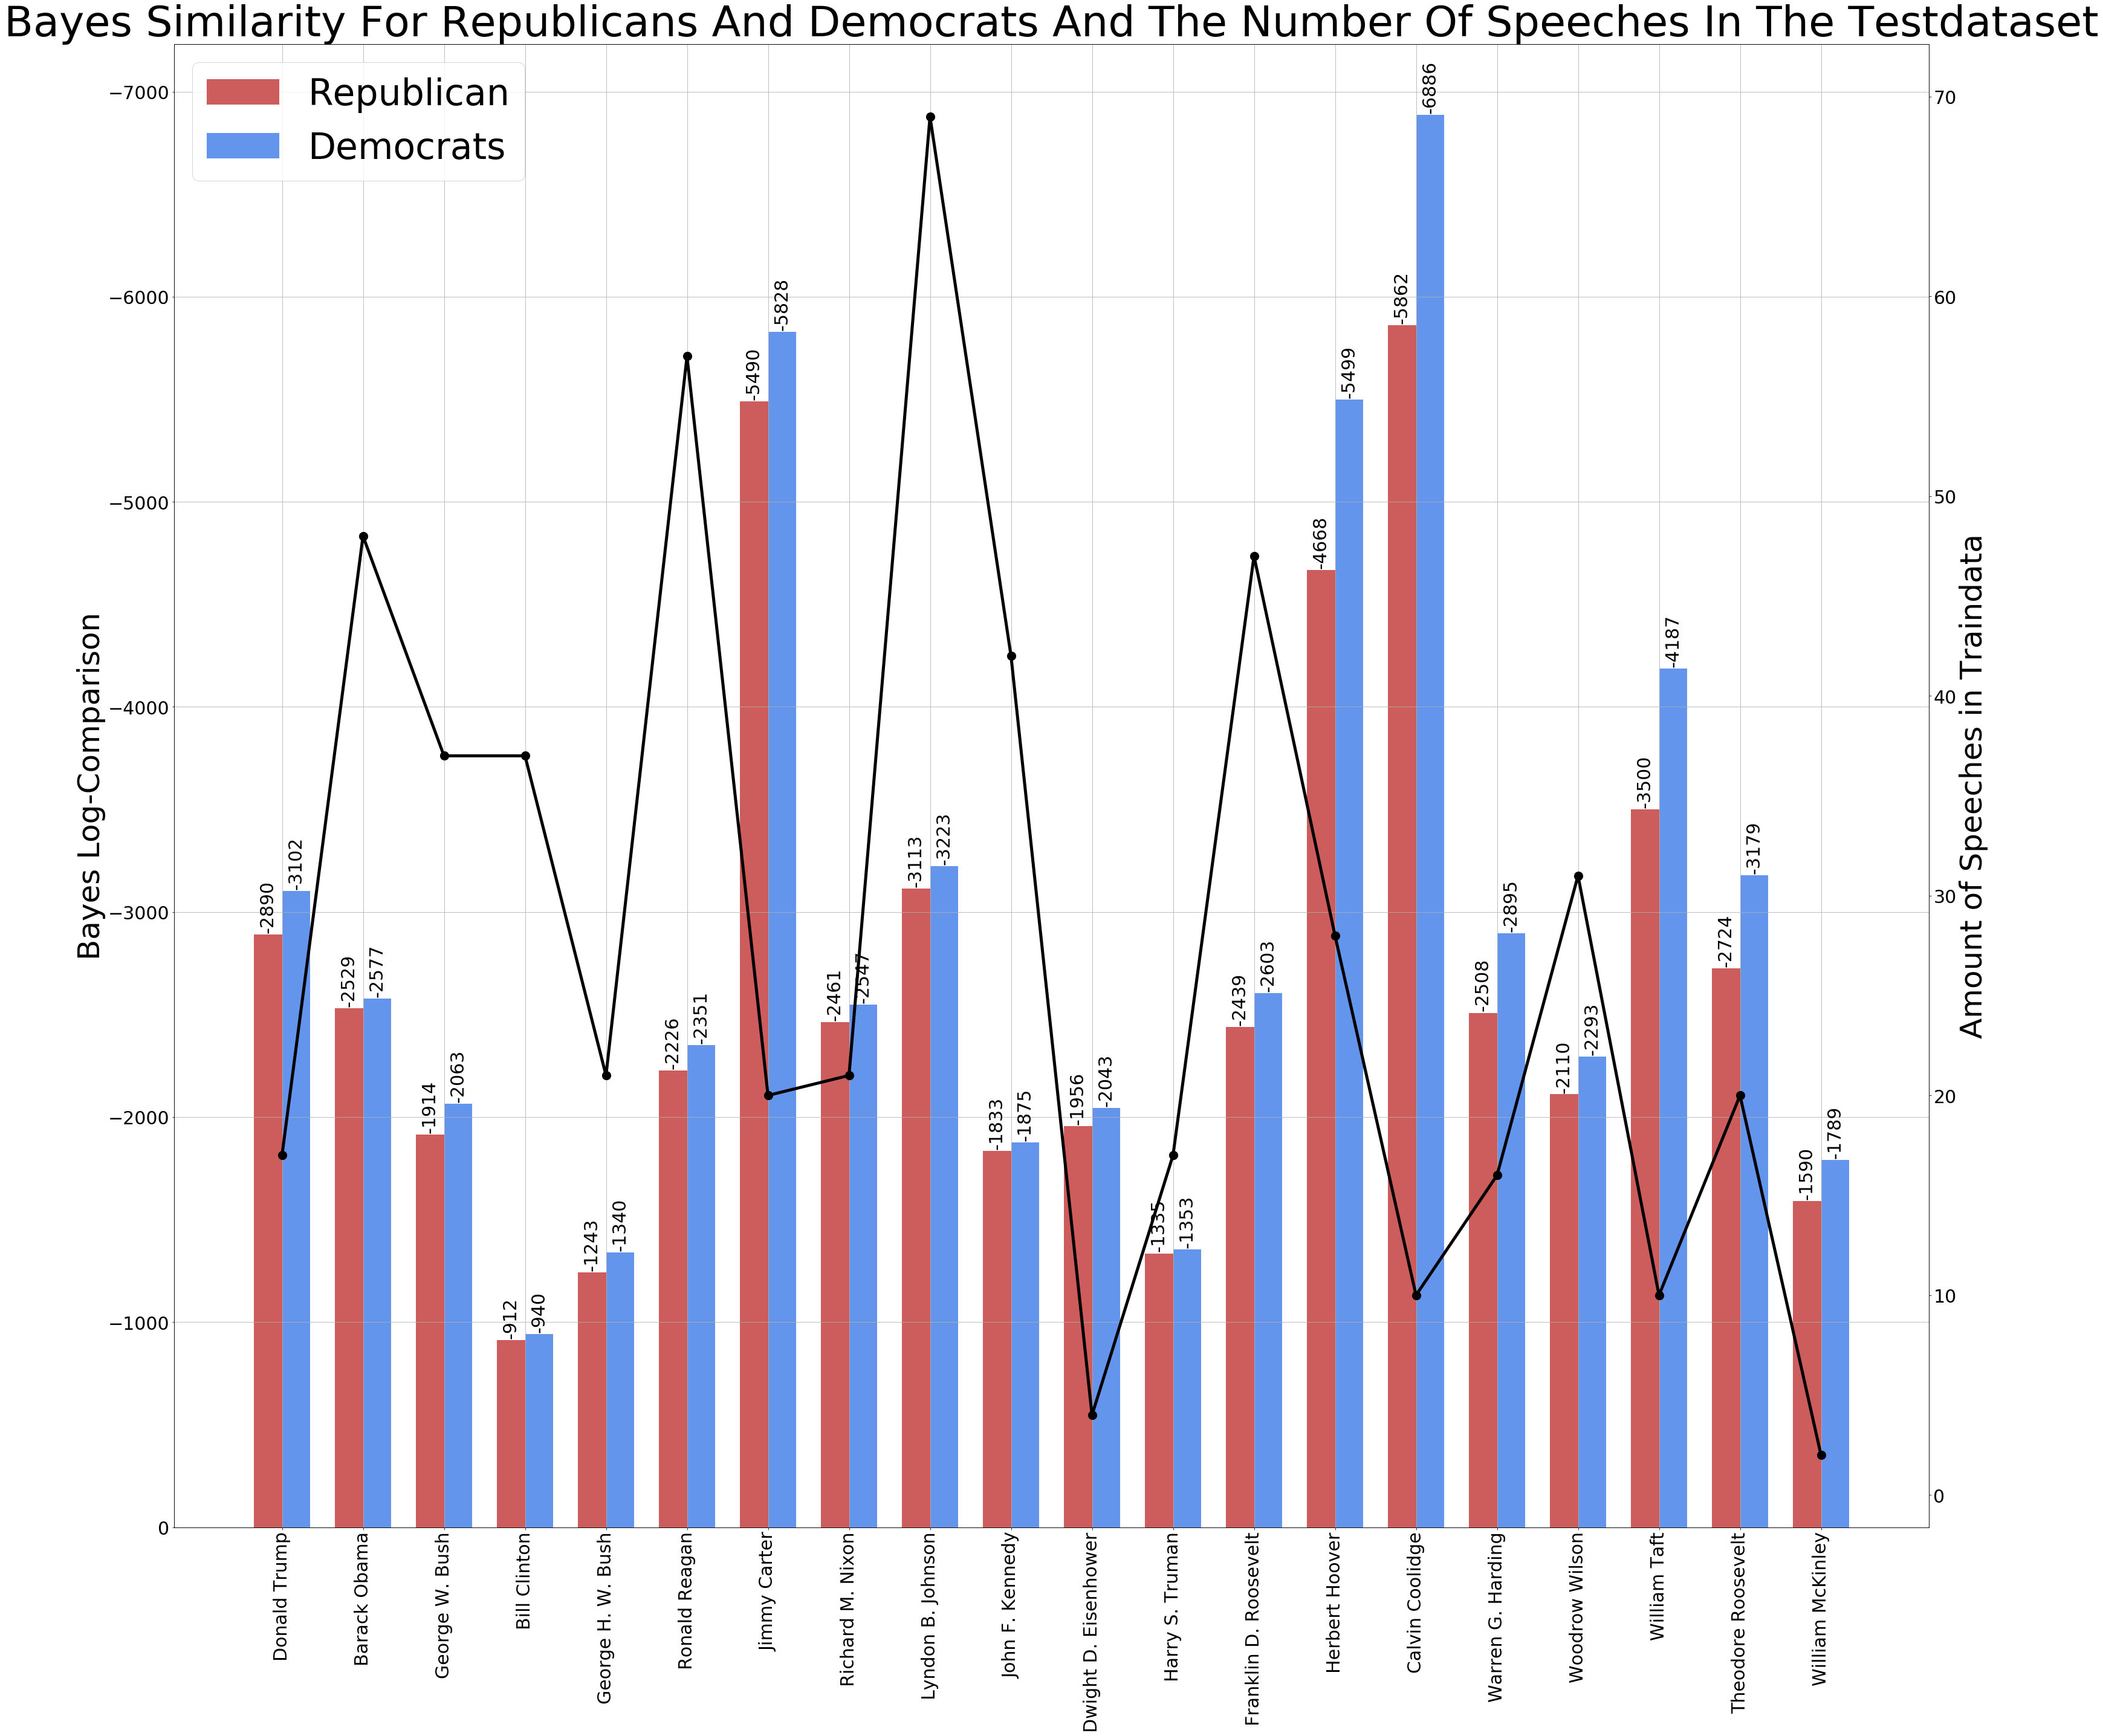

In [19]:
# Barchart des höchsten Wertes und der Anzahl der Reden in den Trainingsdaten
labels = []
rep = []
dem = []
number_train = []
for key in pv_dic:
    
    number_train.append(len(df[df.President == key]))
    rep.append(president_dic[key]["prob_rep"])
    dem.append(president_dic[key]["prob_dem"])
    labels.append(key)


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(50,40))
rects1 = ax.bar(x - width/2, rep, width, label='Republican', color = "indianred")
rects2 = ax.bar(x + width/2, dem, width, label='Democrats', color = "cornflowerblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Bayes Log-Comparison', size = 50)
ax.set_title('Bayes Similarity For Republicans And Democrats And The Number Of Speeches In The Testdataset', size =70)
plt.yticks(fontsize = 30)
ax.set_xticks(x)
ax.set_xticklabels(labels, size = 30, rotation = 90)
ax.legend(loc = 2, fontsize = 60)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        height = int(height)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation = 90, size = 30)

autolabel(rects1)
autolabel(rects2)
plt.gca().invert_yaxis()

# Zweite Y-Achse

ax2 = ax.twinx()
ax2.set_ylabel('Amount of Speeches in Traindata', color="black", size = 50)  # we already handled the x-label with ax1
ax2.plot(x, number_train, color="black", lw = 5)
ax2.scatter(x, number_train, color="black", s = 200)
ax2.tick_params(axis='y', labelcolor="black")
plt.yticks(fontsize = 30)

fig.tight_layout()
ax.grid(True)
plt.show()
fig.savefig("Train_amount.svg")

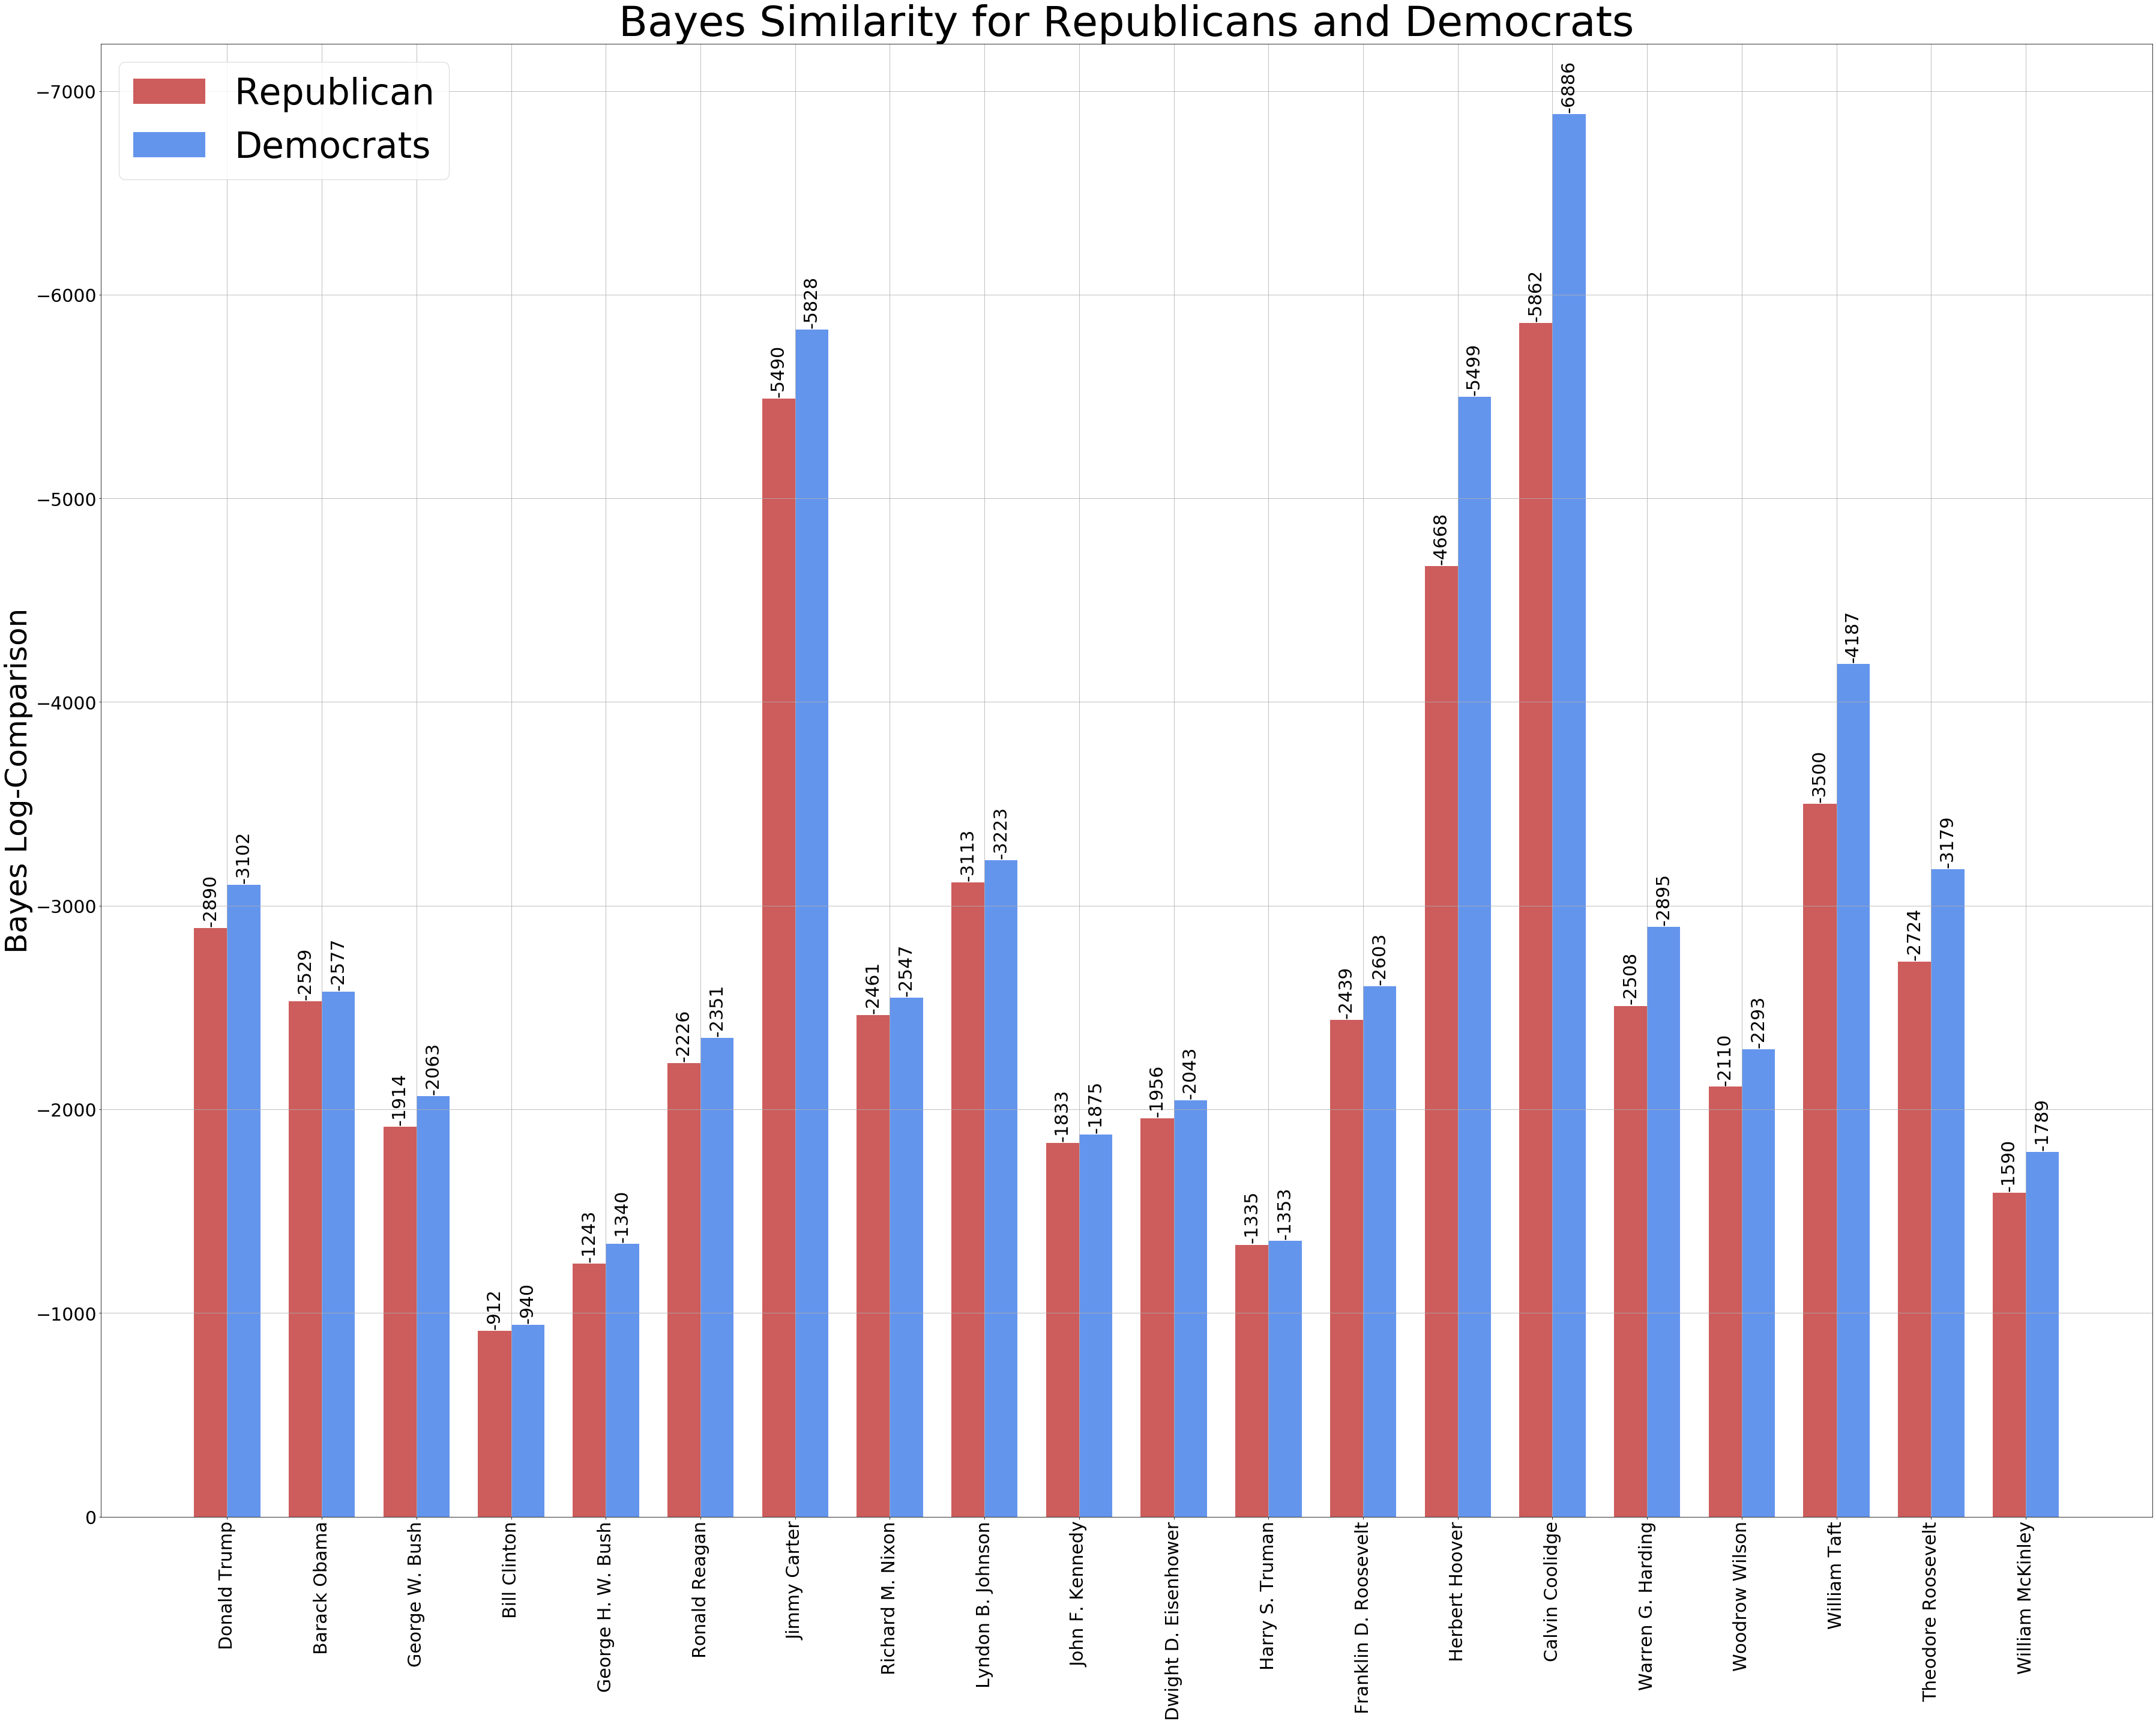

In [20]:
# Barchart der Präsidenten und deren Werte für jeweils Demokratisch und Republikanisch.
labels = []
rep = []
dem = []
for key in pv_dic:
    
    rep.append(president_dic[key]["prob_rep"])
    dem.append(president_dic[key]["prob_dem"])
    labels.append(key)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(50,40))
rects1 = ax.bar(x - width/2, rep, width, label='Republican', color = "indianred")
rects2 = ax.bar(x + width/2, dem, width, label='Democrats', color = "cornflowerblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Bayes Log-Comparison', size = 50)
ax.set_title('Bayes Similarity for Republicans and Democrats', size =70)
plt.yticks(fontsize = 30)
ax.set_xticks(x)
ax.set_xticklabels(labels, size = 30, rotation = 90)
ax.legend(loc = 2, fontsize = 60)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        height = int(height)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation = 90, size = 30)

autolabel(rects1)
autolabel(rects2)
ax.grid(True)
fig.tight_layout()
plt.gca().invert_yaxis()
plt.show()
fig.savefig("Dem_Rep.svg")

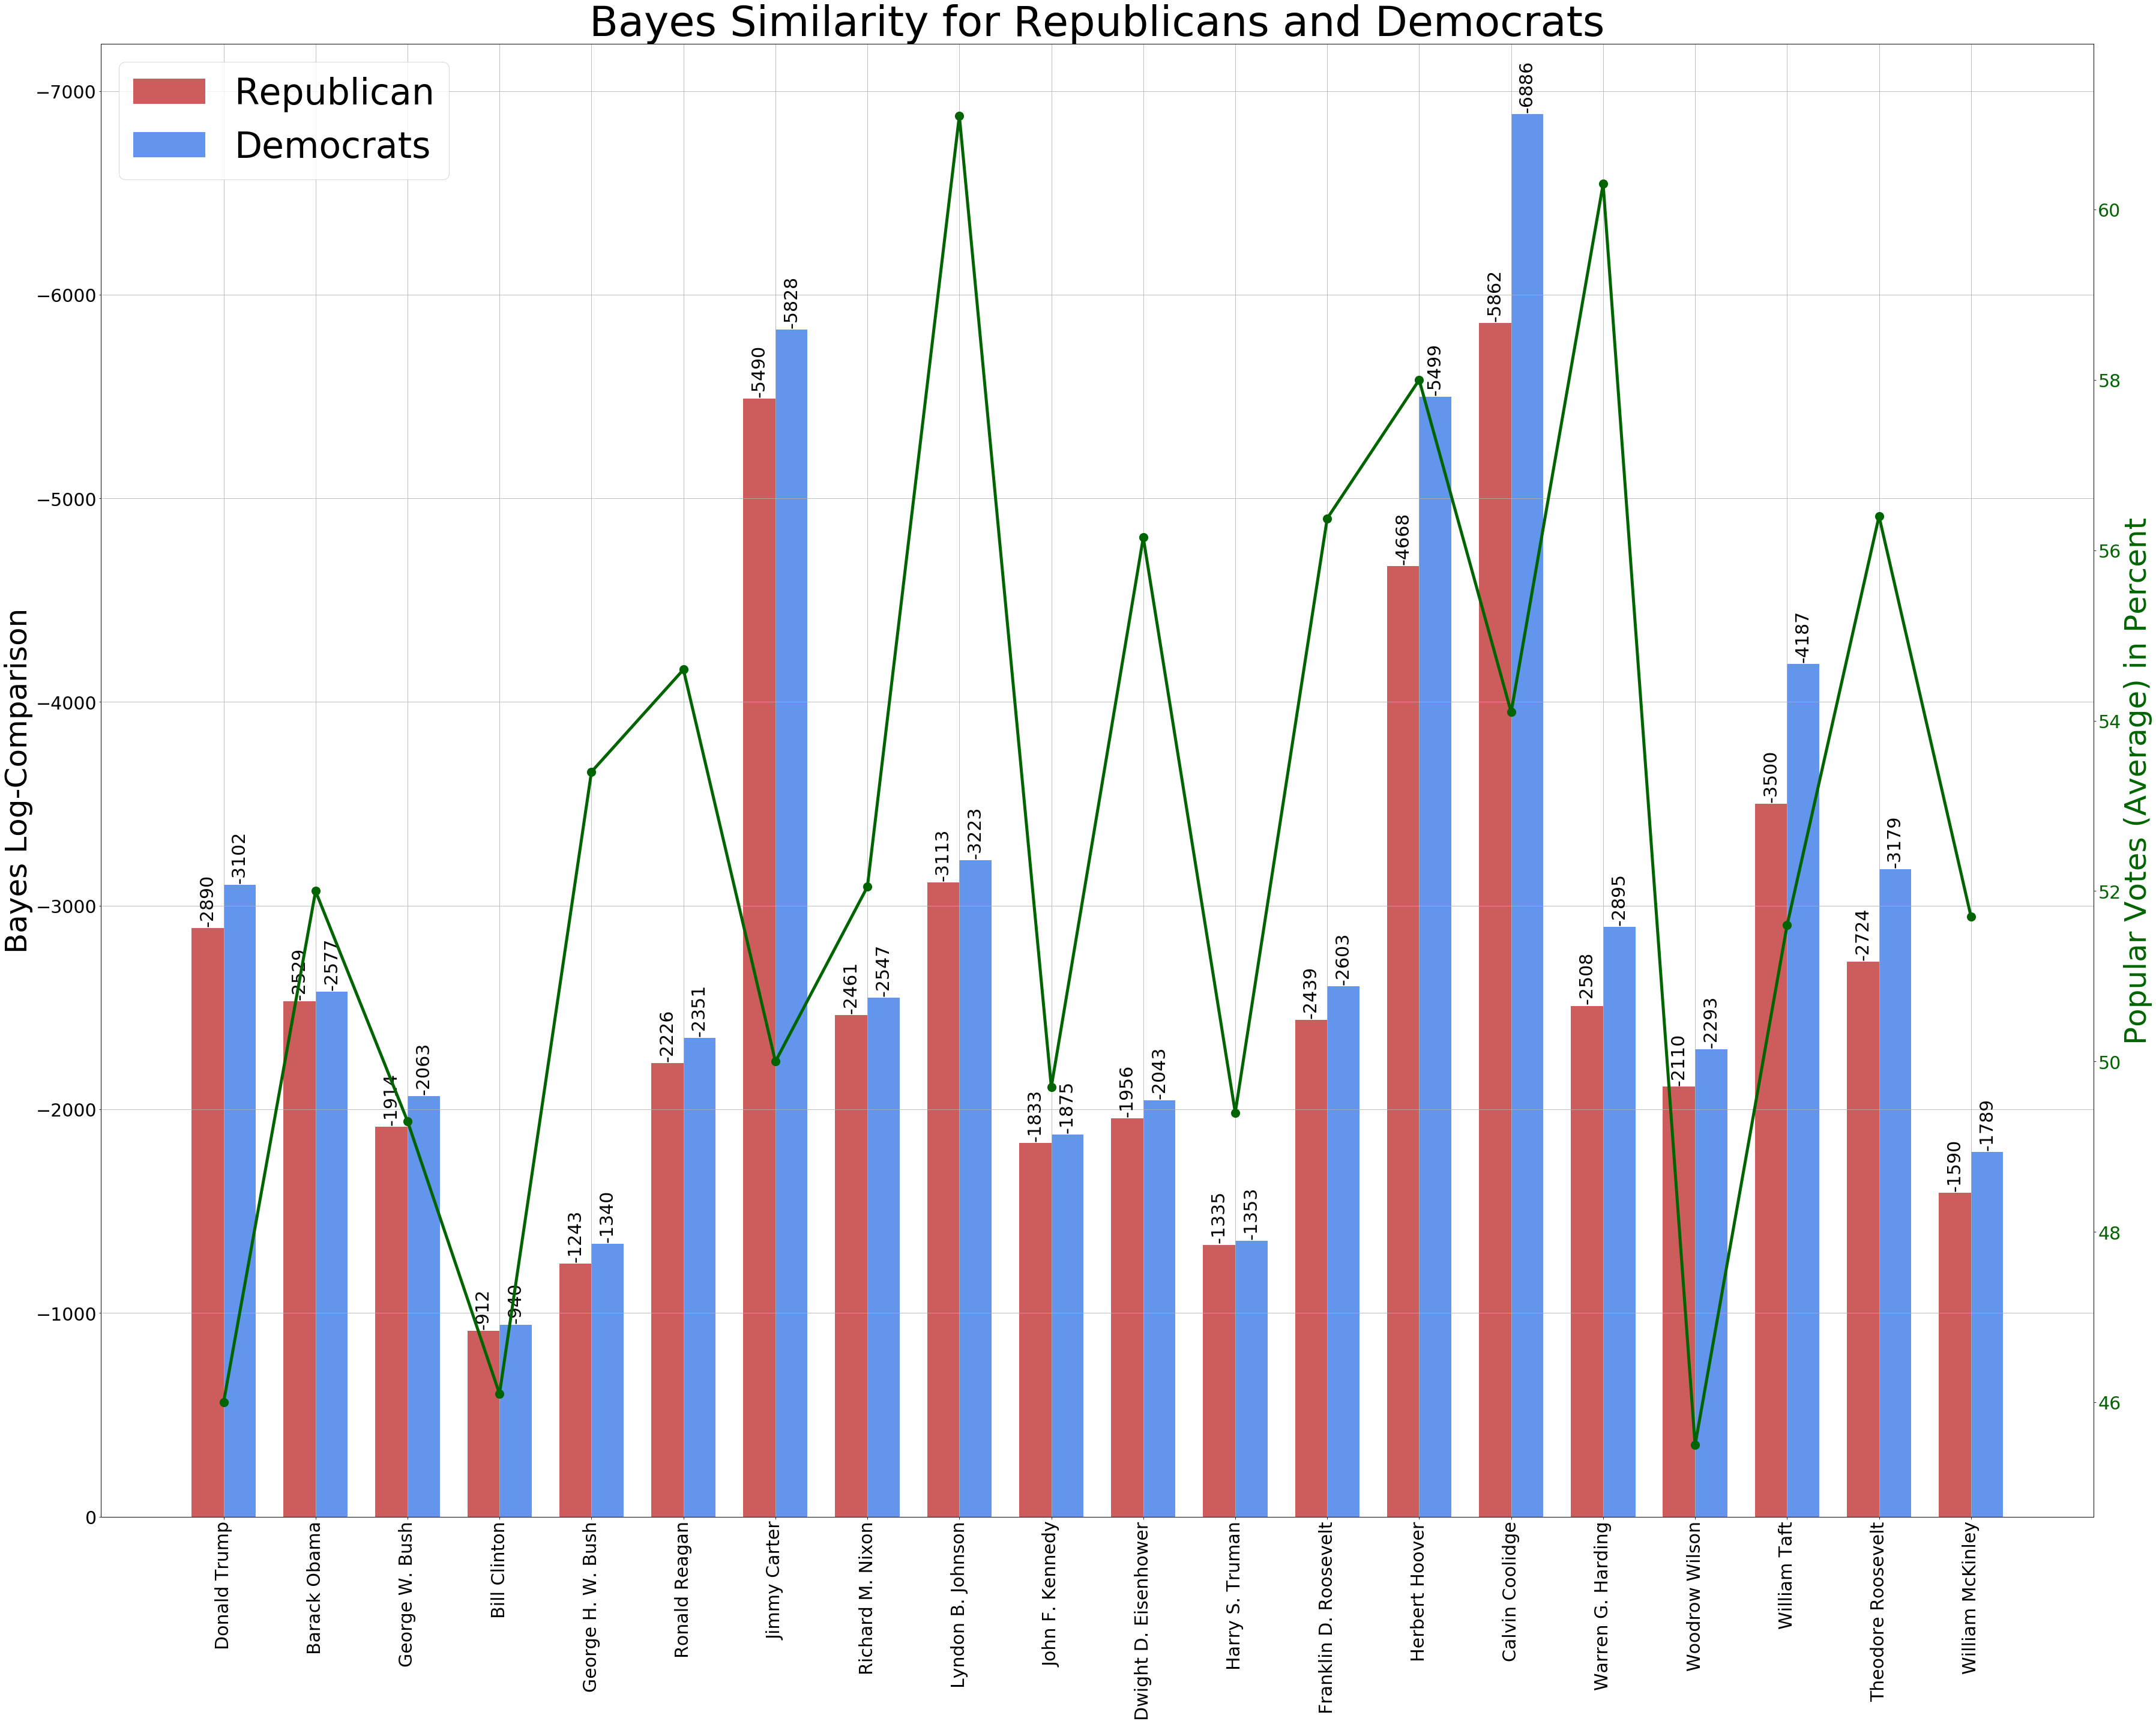

In [21]:
# Barchart der Präsidenten und deren Werte für jeweils Demokratisch und Republikanisch. 
# Hinzufügen einer weiteren Y-Achse um die Popular Votes mit auf der Grafik einzubringen
labels = []
rep = []
dem = []
pv_rating = []
for key in pv_dic:
    
    rep.append(president_dic[key]["prob_rep"])
    dem.append(president_dic[key]["prob_dem"])
    pv_rating.append(pv_dic[key])
    labels.append(key)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(50,40))
rects1 = ax.bar(x - width/2, rep, width, label='Republican', color = "indianred")
rects2 = ax.bar(x + width/2, dem, width, label='Democrats', color = "cornflowerblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Bayes Log-Comparison', size = 50)
ax.set_title('Bayes Similarity for Republicans and Democrats', size =70)
plt.yticks(fontsize = 30)
ax.set_xticks(x)
ax.set_xticklabels(labels, size = 30, rotation = 90)
ax.legend(loc = 2, fontsize = 60)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        height = int(height)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation = 90, size = 30)

autolabel(rects1)
autolabel(rects2)
plt.gca().invert_yaxis()

# Zweite Y-Achse

ax2 = ax.twinx()
ax2.set_ylabel('Popular Votes (Average) in Percent', color="darkgreen", size = 50)  # we already handled the x-label with ax1
ax2.plot(x, pv_rating, color="darkgreen", lw = 5)
ax2.scatter(x, pv_rating, color="darkgreen", s = 200)
ax2.tick_params(axis='y', labelcolor="darkgreen")
plt.yticks(fontsize = 30)

fig.tight_layout()
ax.grid(True)
plt.show()
fig.savefig("PV_Rep_Dem.svg")